<a href="https://colab.research.google.com/github/udaydaroch/DeepLearning/blob/main/Cosc440_assignment_3_2025_(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COSC440 Assignment 3: Building a Convolutional Autoencoder

In the first part of the assignment, we will be introducing and getting familiar with the concept of a convolutional autoencoder. We will use this to denoise images from the CIFAR10 dataset. In the second part we will attempt to apply to this model to explore unsupervised classification.

## Introduction
Autoencoders are really cool. They use this architecture of encoder + decoder to learn data representation in an unsupervised manner. Sounds complicated? Let's break it down.


![Autoencoders](https://drive.google.com/uc?export=view&id=18iU9_yZfqs2QlTPbaibzkMtdIekLuPj2)

As we can see, the autoencoder is divided roughly in two parts: the encoder that encodes the input to a "code", or internal representation, that is reduced in dimensions, and the decoder that decodes the "code" to an output that is the same dimensions as the input.

The autoencoder tries to learn a function h(x)≈x. In other words, it is trying to learn an approximation to the identity function, so as to output x'  that is similar to x. This may sound like a pretty trivial task, why not just use the identity function? Well, it's impossible to find a perfect representation of the identity function since we reduced dimensionality of the input into the code during the encoding part, and try to "reconstruct" the original image using only the dimensionally reduced code. E.x. Given an input of a 10x10 image, and a hidden size of 50, the encoder is forced to learn a compressed representation of the image (from 100 units to 50 units). This encoding is almost always lossy, but the point is that we train the encoder to recognize important structures in the input and throw away the unimportant noise.

### In this part, we will be building a denoising autoencoder. The input of the autoencoder will be a noisy version of our training data and we will train the model to predict the noise free version.

## Deconvolution (Transposed-Convolution)
Conceptually, deconvolution reverses the effects of convolution. Convolution with a stride of larger than 1 reduces the size of the input, while deconvolution can be described as a "fractional stride" convolution, it upscales the size of the input. Here's a visualisation.

#### Convolution with stride = 2 *going from bigger to smaller*:
![convolution.gif](https://drive.google.com/uc?export=view&id=1TjSgMinNQ629TrdEmcVjKuwWZ9MGMfg7)

#### Deconvolution (convolution with fractional stride) *going from smaller to bigger*:
![deconvolution.gif](https://drive.google.com/uc?export=view&id=1opzIaiShA5_nLT5Y5Kh_GqPT9IlVeQF5)

As we can see, deconvolution upscales the input. This is important for our decoder as its job is to upscale the encoded and compressed internal representation to its original size.
Concretely, this is how we implement deconvolution in tensorflow:

``` Python
tf.nn.conv2d_transpose(
    value, # input tensor: A 4-D Tensor of type float and shape [batch, height, width, in_channels]
    filter, # filter tensor: A 4-D Tensor with shape [height, width, output_channels, in_channels]
    output_shape, # A 1-D Tensor representing the output shape of the deconvolution op.
    strides, # A list of ints. The stride of the sliding window for each dimension of the input tensor.
    padding='SAME'
)
```

## Setup

Enabling the GPU:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

In [ ]:
# This makes sure that we are using Tensorflow 2
try:
  # Note: %tensorflow_version only exists in Google Colab
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import numpy as np

tf.random.set_seed(1337)  # setting seed for later part of assignment. DO NOT CHANGE

print(tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.18.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


If set up correctly, you should see GPU Available: [PhysicalDevice]

### Noise Functions

In order to test our autoencoder, we need to add some noise to our CIFAR10 data points. The goal for the autoencoder is to learn the important underlying features (the objects) of the data and to ignore the extra noise.

Implement the below different noise functions.

In [ ]:
"""
This function adds no noise, we use this as a way of comparing the
autoencoder when there's no input noise
"""
def no_noise(x):
  # TODO
  return tf.identity(x)

"""
This function should add a random uniform tensor of the shape of x between
-0.3 to 0.3 to x.

It should then "clip" x to between 0 and 1 (hint: check out tf.clip_by_value)
"""
def random_noise(x):
  # TODO
  x = tf.cast(x, tf.float32)
  noise = tf.random.uniform(shape=tf.shape(x), minval=-0.3, maxval=0.3, dtype=tf.float32)
  noisy_x = x + noise
  clipped_x = tf.clip_by_value(noisy_x, 0.0, 1.0)
  return clipped_x

"""
This function should multiply a random uniform tensor of the shape of x between
0 to 2.0 to x.

It should then "clip" x to between 0 and 1 (hint: check out tf.clip_by_value)
"""
def random_scale(x):
  # TODO
  x = tf.cast(x, tf.float32)
  scale_factors = tf.random.uniform(shape=tf.shape(x), minval=0.0, maxval=2.0, dtype=tf.float32)
  scaled_x = x * scale_factors
  clipped_x = tf.clip_by_value(scaled_x, 0.0, 1.0)

  return clipped_x
# some "unit tests"
x = [[0.3,0.1],[0.2,0]]
y = [[0.1,1],[0,0.33]]
result_1 = random_noise(x)
result_2 = random_scale(x)
result_3 = random_noise(y)
result_4 = random_scale(y)

for res in [result_1, result_2, result_3, result_4]:
  assert(res.shape == (2,2))
  assert(res.dtype == tf.float32)
  assert(np.max(np.array(res)) <= 1.0)
  assert(np.min(np.array(res)) >= 0.0)

print("Noise functions look good!")

Noise functions look good!


## Architecture Definition
We want to construct the following architecture:

(Due to the limitations of the rendering engine I'm using, there is a small inaccuracy: the connections in the decoder *{the red prisms}* should be upscaling, not downscaling like in the encoder. - original creator of lab)

Shapes:

Layer | Shape of Output
--- | ---
Input | (batch_size, 32, 32, 3)
encoder_conv_1    | (batch_size, 16, 16, 8)
encoder_conv_2    | (batch_size, 8, 8, 16)  
encoder_conv_3    | (batch_size, 4, 4, 32)  
decoder_deconv_1  | (batch_size, 8, 8, 16)  
decoder_deconv_2  | (batch_size, 16, 16, 8)
decoder_deconv_3  | (batch_size, 32, 32, 3)

![Architecture](https://drive.usercontent.google.com/download?id=1-jZFte-UE-L-lFiTHlAhgFyDDYPXRVvT&export=view)


### **Encoder**
Let's first build the encoding portion of our autoencoder. We're going to directly use Keras layers to help us out by subclassing the Layer class. See this for more information on subclassing Layers: https://www.tensorflow.org/guide/keras/custom_layers_and_models

This should have 3 convolution layers. The layers should be initialized with random normal with standard deviation of 0.1. Also, please use an activation layer of leaky_relu with alpha=0.2. Use a kernel size of 3 and padding of same. Think about what the filter count and stride should be by looking at the output shapes of the architecture.

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder_conv_1 = tf.keras.layers.Conv2D(
            filters=8, kernel_size=3, strides=2, padding='SAME',
            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
        )
        self.encoder_conv_2 = tf.keras.layers.Conv2D(
            filters=16, kernel_size=3, strides=2, padding='SAME',
            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
        )
        self.encoder_conv_3 = tf.keras.layers.Conv2D(
            filters=32, kernel_size=3, strides=2, padding='SAME',
            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
        )
        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)

    def call(self, images):
        x = self.encoder_conv_1(images)
        x = self.leaky_relu(x)
        x = self.encoder_conv_2(x)
        x = self.leaky_relu(x)
        x = self.encoder_conv_3(x)
        x = self.leaky_relu(x)
        return x


### **Decoder**
Now let's build the decoder portion of our autoencoder.

This should have 3 deconvolution layers. For the first deconvolution layer please use tf.nn.conv2d_transpose to implement the deconvolution. The other two may be keras layers (Conv2DTranspose). Use the same kernel / activation /initialization as the encoder.

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder_deconv_1 = self.add_weight(
            shape=[3, 3, 16, 32],
            initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
            trainable=True,
            name='w_deconv1'
        )

        self.decoder_deconv_2 = tf.keras.layers.Conv2DTranspose(
            filters=8, kernel_size=3, strides=2, padding='SAME',
            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
        )
        self.decoder_deconv_3 = tf.keras.layers.Conv2DTranspose(
            filters=3, kernel_size=3, strides=2, padding='SAME',
            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
        )
        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)

    def call(self, encoder_output):

        batch_size = tf.shape(encoder_output)[0]
        output_shape = [batch_size, 8, 8, 16]
        x = tf.nn.conv2d_transpose(
            encoder_output,
            self.decoder_deconv_1,
            output_shape=output_shape,
            strides=[1, 2, 2, 1],
            padding='SAME'
        )
        x = self.leaky_relu(x)

        x = self.decoder_deconv_2(x)
        x = self.leaky_relu(x)
        x = self.decoder_deconv_3(x)
        x = self.leaky_relu(x)
        return x

Now let's combine everything to create our autoencoder.

Fill in the call and loss_function.

Our loss equation is:
$$\sum (y - x)^2$$


y: the encoded image

x: the original corrupted image

In [ ]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, images):
       encoded = self.encoder(images)
       decoded = self.decoder(encoded)
       return decoded

    def loss_function(self, encoded, originals):
      encoded = tf.dtypes.cast(encoded, tf.float32)
      originals = tf.dtypes.cast(originals, tf.float32)
      return tf.reduce_sum(tf.math.squared_difference(encoded, originals))

### Train Loop
Next, please fill in the train loop for training.  

In [ ]:
@tf.function
def train(model, optimizer, images, noise_function):
  corrupted = noise_function(images)
  uncorrupted = images

  with tf.GradientTape() as tape:
    predictions = model(corrupted)
    loss = model.loss_function(predictions, uncorrupted)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

### Total Loss
This function that calculates the total loss over the entire data set,
we use this to track the loss over each epoch

In [ ]:
@tf.function
def total_loss(model, images, noise_function):
  corrupted = noise_function(images)
  uncorrupted = images
  predictions = model(corrupted)
  sum_loss = model.loss_function(predictions, uncorrupted)
  return sum_loss

## Test your autoencoder

Run the following code to run your autoencoder. You should see it print out images and the total loss of the autoencoder each epoch.

Be aware that the loss generally should go down each epoch, but might not always. Use your judgement and check with the TA after this runs.

It probably will take around 5 minutes (make sure you are using a GPU!)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Showing autoencoder for noise function: <function random_noise at 0x7b6c3ca96020>


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch:  0
Total Loss: 227407.703125


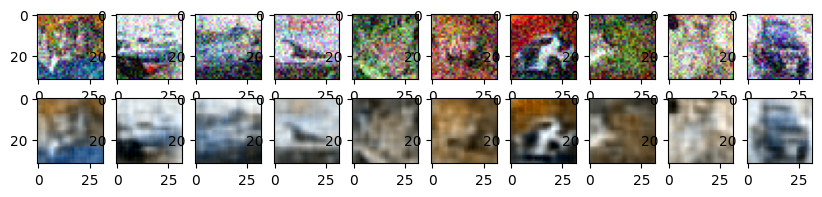

Epoch:  1
Total Loss: 208415.203125


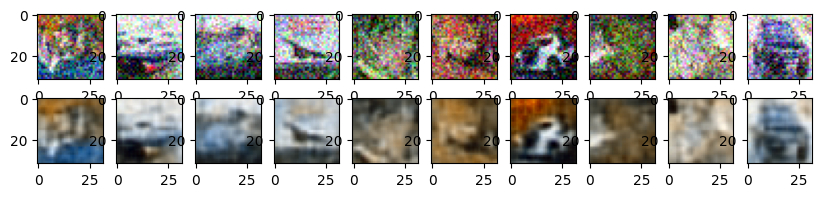

Epoch:  2
Total Loss: 207361.0


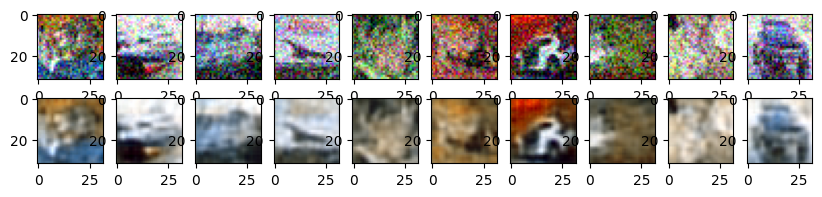

Epoch:  3
Total Loss: 171392.125


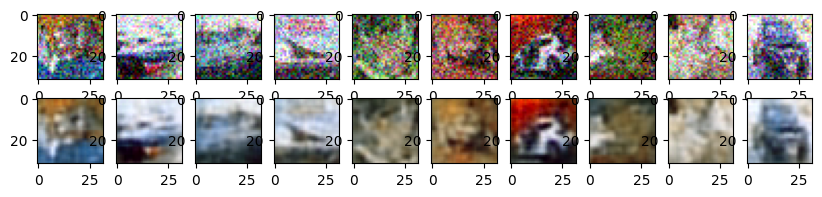

Epoch:  4
Total Loss: 170218.265625


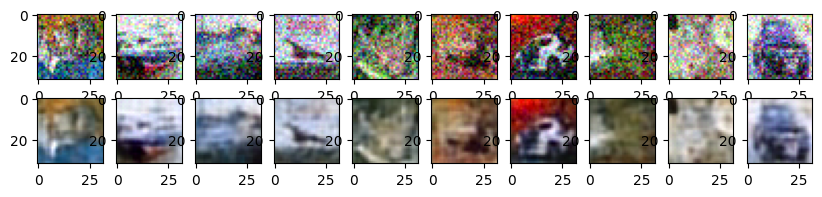

Epoch:  5
Total Loss: 167413.59375


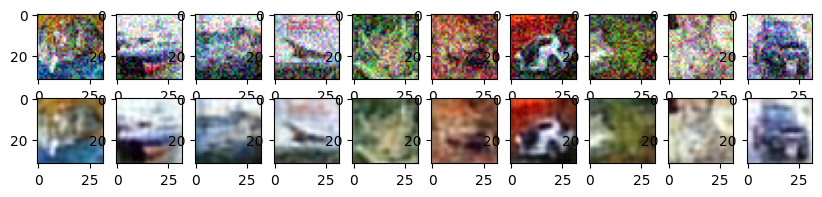

Epoch:  6
Total Loss: 151311.78125


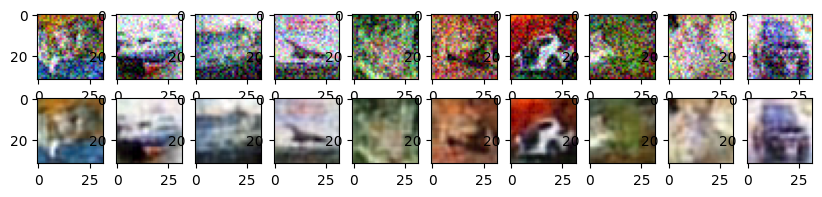

Epoch:  7
Total Loss: 145410.875


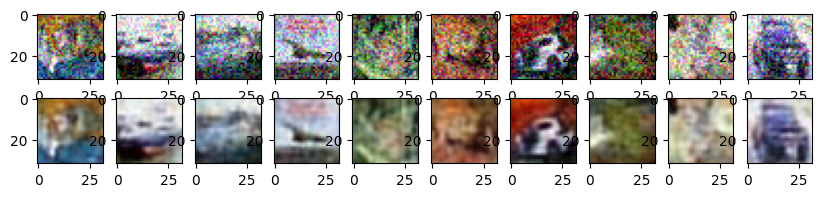

Epoch:  8
Total Loss: 143029.1875


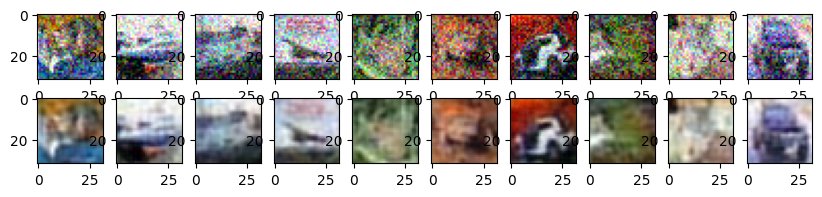

Epoch:  9
Total Loss: 142205.125


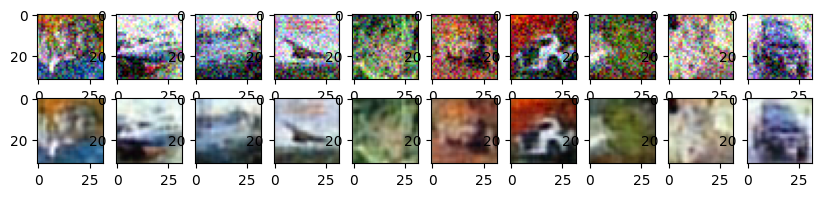

Epoch:  10
Total Loss: 155645.1875


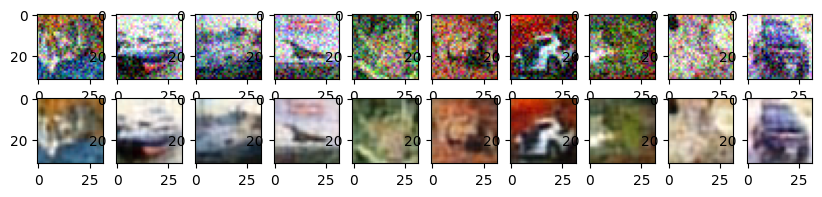

Epoch:  11
Total Loss: 141777.25


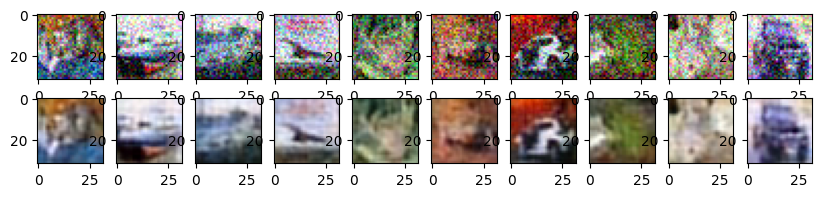

Epoch:  12
Total Loss: 146111.34375


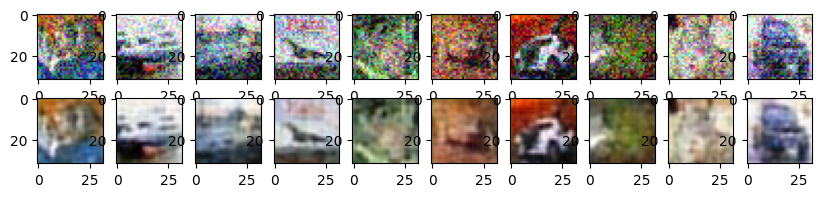

Epoch:  13
Total Loss: 139284.375


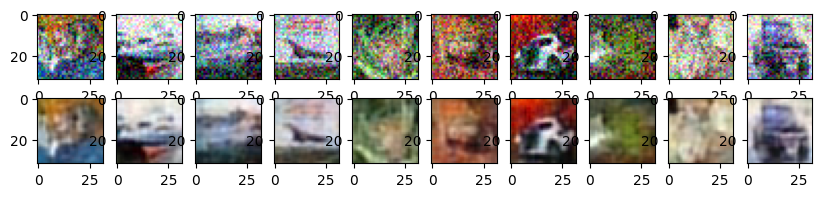

Epoch:  14
Total Loss: 147495.890625


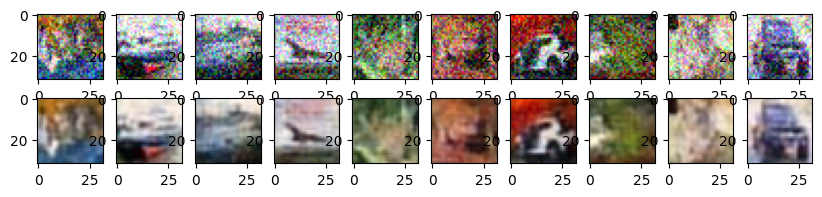

Epoch:  15
Total Loss: 135468.75


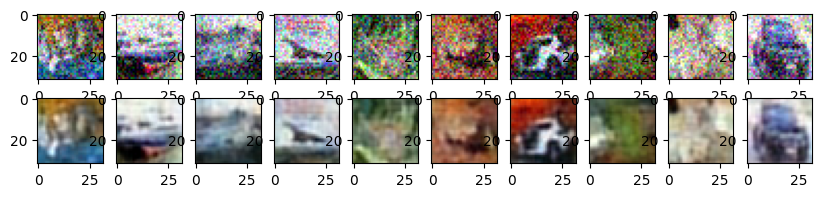

Epoch:  16
Total Loss: 136221.703125


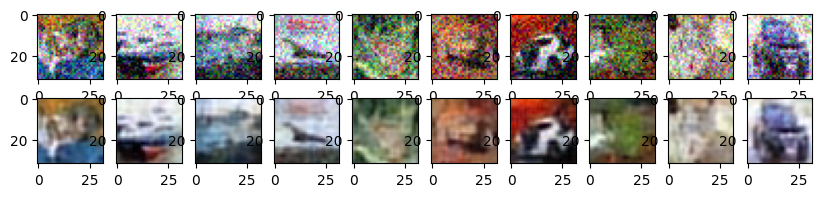

Epoch:  17
Total Loss: 137635.3125


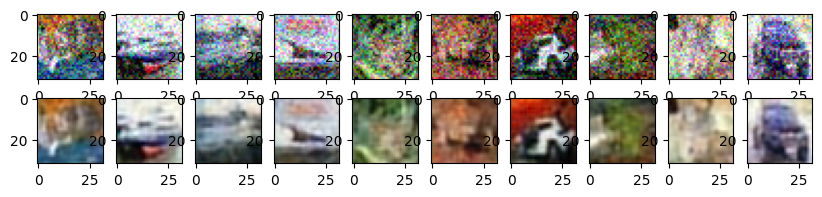

Epoch:  18
Total Loss: 142101.109375


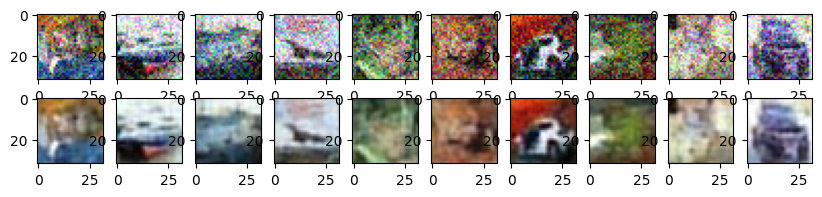

Epoch:  19
Total Loss: 131707.71875


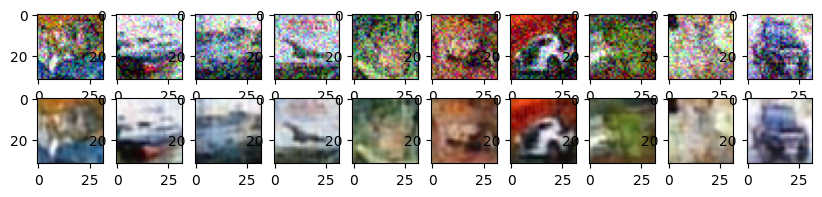

Epoch:  20
Total Loss: 132241.421875


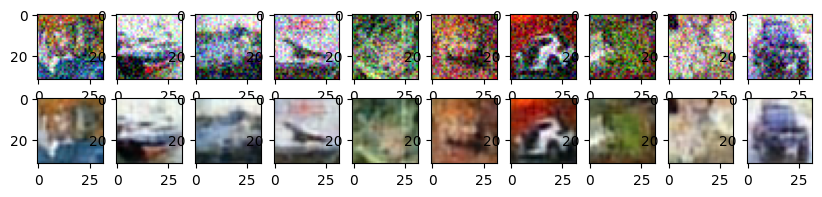

Epoch:  21
Total Loss: 130249.8515625


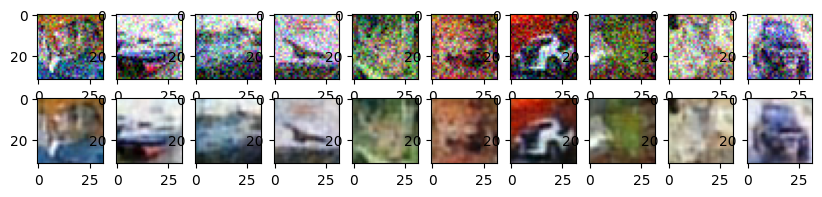

Epoch:  22
Total Loss: 139470.484375


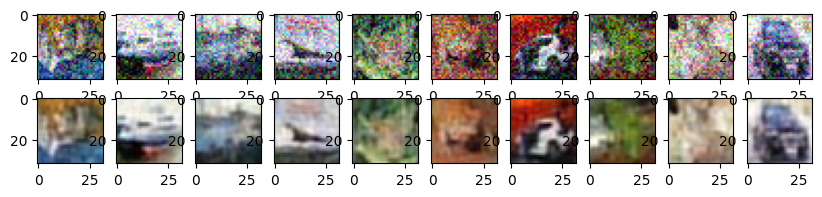

Epoch:  23
Total Loss: 132835.359375


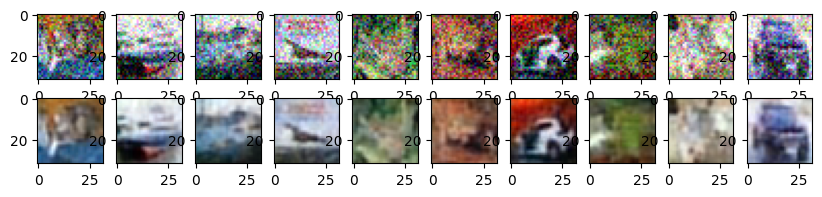

Epoch:  24
Total Loss: 132487.53125


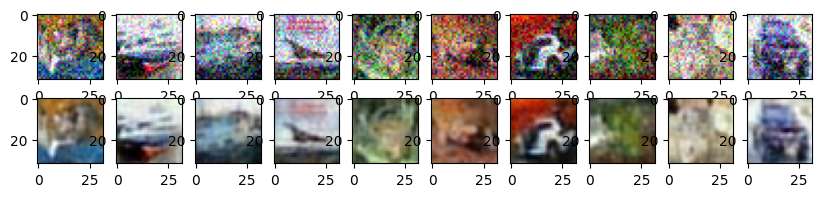

In [ ]:
# This code is helper code to plot the cifar10 images so you
# can see your autoencoder in action!
%matplotlib inline
import matplotlib.pyplot as plt

n_examples = 10
batch_size = 100
n_epochs = 25


(train_images, _), (test_images, _) = tf.keras.datasets.cifar10.load_data()
test_images = test_images / 255
example_images = test_images[:n_examples]
train_images = train_images / 255

def showImages(model, noise_function):
  corrupted = noise_function(example_images)
  recon = tf.clip_by_value(model(corrupted), 0, 1)

  fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
  for example_i in range(n_examples):
      axs[0][example_i].imshow(corrupted[example_i])
      axs[1][example_i].imshow(recon[example_i])
  plt.show()


# Runs the autoencoder
# We'll just be testing the random_noise function for training
for noise_function in [random_noise]:
  print("Showing autoencoder for noise function: {0}".format(noise_function))
  model = AutoEncoder()
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
  for i in range(n_epochs):
    for j in range(0, len(train_images), batch_size):
      train(model, optimizer, train_images[j:j+batch_size], noise_function)

    print("Epoch: ", i)
    sum_loss = total_loss(model, test_images, noise_function)
    print("Total Loss: {0}".format(sum_loss))
    showImages(model, noise_function)

## Checkpoint!

Check to see if your denoiser works! If it works, you should see the autoencoder images remove noise from the original inputs. The top row for each epoch is the input image and the bottom is the autoencoded image.

If you wish to you can check out how the different noise functions are handled by the autoencoder.

## Visualizing the Data Representation

We can now visualize where CIFAR10 data points are positioned in the latent space. Run the visualization code below to open Tensorboard. On the bottom right you can switch visualiztion to T-SNE or PCA for a 3D representation.

Note: You may have to run the cell twice for it to actually render

In [ ]:
# from sklearn.manifold import TSNE
# from mpl_toolkits.mplot3d import Axes3D

# NUM_SAMPLES = 1000

# (train_images, train_labels),(test_images,test_labels) = tf.keras.datasets.cifar10.load_data()
# test_images = test_images / 255
# train_images = train_images / 255

# z_test = model.encoder(tf.reshape(test_images, [-1, 32, 32, 3]))
# z_test = np.reshape(z_test, [len(test_images), -1])

# z_train = model.encoder(tf.reshape(train_images, [-1, 32, 32, 3]))
# z_train = np.reshape(z_train, [len(train_images), -1])

# import torch
# from torch.utils.tensorboard import SummaryWriter

# %load_ext tensorboard

# log_dir = "tensorboard/"
# writer = SummaryWriter(log_dir)

# total_images = len(test_images)

# z_test_tensor = torch.tensor(z_test[:total_images])
# test_labels_tensor = [int(test_labels[i]) for i in range(total_images)]
# test_images_tensor = torch.tensor(test_images[:total_images]).permute(0, 3, 1, 2)

# writer.add_embedding(z_test_tensor, metadata=test_labels_tensor, label_img=test_images_tensor)

# %tensorboard --logdir {log_dir}

# writer.close()

Now that we have a trained version of the auto-encoder we want to take the output of just the encoder and perform k-mean clustering on it. Fill out the code below and perform k-mean clustering on the latent space of the training examples.

Note: Running k-means should take about 2 minutes

In [ ]:
# from sklearn.cluster import KMeans
# num_clusters = 10
# kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10, max_iter=1000)
# encoder = model.encoder
# # TODO create latent space embeddings of training images
# latent_representations = encoder.call(tf.reshape(train_images, [-1, 32, 32, 3]))
# latent_representations = tf.reshape(latent_representations, (len(train_images), -1))
# assert(tf.is_tensor(latent_representations))
# assert(latent_representations.shape[0] == 50000)
# assert(latent_representations.shape[1] == 512)
# print('latent_representations is the right shape and type')

# # TODO perform kmeans clustering
# kmeans.fit(latent_representations)

Lets check our class seperations now. In the next cell, group the test images by class, calculate their latent space embeddings, and run kmeans.predict on them all.

Use this to calculate the mode of the predictions for each of the classes.

In [ ]:
# from scipy import stats
# NUM_CLASSES = 10

# for i in range(NUM_CLASSES):
#   test_filter = test_labels == i
#   test_images_class_i = test_images[test_filter[:, 0]]
#   test_labels_class_i = test_labels[test_filter[:, 0]]
#   # TODO create latent embeddings for this class
#   latent_representations = encoder.call(tf.reshape(test_images_class_i, [-1, 32, 32, 3]))
#   latent_representations = tf.reshape(latent_representations, (len(test_images_class_i), -1))
#   # TODO predict with K means and calculate the mode of these predictions for this class
#   predictions = kmeans.predict(latent_representations)
#   print(stats.mode(predictions))

With that done, we should see that our class seperation isn't the best. We can tell by the fact that our test images when grouped by their labels have the same mode as other classes when K-mean clustered. This means that our seperation of classes in latent space isn't sufficiently large to be a good classifier.

To investigate the source of this problem, we can embed an image of each class and then retrieve a set of images that have a similar latent space embedding. Run the following code to view these similar images.

In [ ]:
# # This visualization code expects train_images to be an array of all training images,
# # and train_latent_representations to be an array of all the corresponding image embeddings.


# def find_similar_images(images, latent_representations, image_number, K=8):
#     # Find closest K images using Euclidean distance
#     query_z = latent_representations[i]
#     dist = tf.norm(tf.expand_dims(query_z, axis=0) - latent_representations, axis=1)

#     # Get the indices of the closest images
#     dist, indices = tf.nn.top_k(-dist, k=K, sorted=True)  # We negate dist to get closest ones

#     images_to_display = images[indices]

#     fig, axs = plt.subplots(1, K, figsize=(10, 2))
#     for example_i in range(8):
#       axs[example_i].imshow(images_to_display[example_i])
#     plt.show()

# train_latent_representations = []
# for j in range(0, len(train_images), batch_size):
#   train_latent_representations.append(encoder.call(train_images[j:j+batch_size]))
# train_latent_representations = tf.concat(train_latent_representations, axis=0)
# train_latent_representations = tf.reshape(train_latent_representations, (len(train_latent_representations), -1))

# for i in range(8):
#     find_similar_images(train_images, train_latent_representations, i)

While our class separation was not high enough to create a good classifier, we can see that images are still being grouped in latent space by their similarity, but images which are close to eachother in the latent aren't always the same class.

Conceptual questions TODO:

Q1) Suppose that we trained our network using the original autoencoder loss function instead of our denoised loss. The only code change would be in your train function where you call:

    ... model.loss_function(..., uncorrupted) ...

to

    ... model.loss_function(..., corrupted) ...
    
Do you think our model could still learn to denoise our data? Explain what you think the network would learn in this case. (1-3 sentences)

Q2) You will notice that if we used our k-means clustering as a classifier it would perform quite poorly.

    Explain why this is occurring (hint: Look at our latent space visualizer) ( 1 - 2 sentences):
    
    What dataset sanitization step could improve this (hint consider the MINST dataset)? ( 1 - 2 sentences ):

Q3): Suppose we have our trained autoencoder and we now sample from the latent space and feed the values into our decoder:

    What would you expect to see if we took a mean latent space value for the boat class and passed it to our decoder?( 1 - 2 sentences ):

    How would this output change as we ‘walked’ from this value to the mean latent space value of the deer class?( 1 - 2 sentences ):


    